## PU Learning For News
Initial work

Mainly to start exploring how to vectorize texts and also identify true negatives

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# nltk.download('punkt')
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

cutoff = 0.8

In [2]:
from sklearn.utils import resample

input_file = "./article_dataset.csv"
df_raw = pd.read_csv(input_file, index_col="id")
df_raw = preprocessing.clean_df(df_raw)
df_raw = df_raw[df_raw['cleaned_text'].str.strip() != ""].copy()
df_raw.reset_index(inplace=True)
df_raw['id'] = df_raw.index
df_raw["clean_title"] = df_raw['title'].apply(preprocessing.clean_text)

df = df_raw.copy()
df = preprocessing.turn_into_pu(df, 0.5)

X_train, X_test, y_train, y_test = preprocessing.test_train_split(df)
y_train.index = X_train.index
y_test_true = df_raw.loc[y_test.index, 'label']

X_train_bootstrap, y_train_bootstrap = resample(
    X_train, y_train,
    replace=True,
    n_samples=len(X_train),
    random_state=42
)
X_train, y_train = X_train_bootstrap, y_train_bootstrap

X_train['tokens'] = X_train['cleaned_text'].apply(lambda x: x.split())
df.head()

,id,title,author,text,label,cleaned_text,clean_title
0,0,House Dem Aide: We Didn't Even See Comey's Let...,Darrell Lucus,House Dem Aide: We Didn't Even See Comey's Let...,1,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...,truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video civilian killed single u airstrike ident...,civilian killed single u airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,iranian woman jailed fictional unpublished sto...


## Vectorizing Text
TF-IDF words

In [3]:
import time

start_time = time.time()

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

pca_logistic = PCA(n_components=6)
principal_components_logistic = pca_logistic.fit_transform(tfidf_df)
print("Explained Variance: ", pca_logistic.explained_variance_ratio_.cumsum())
end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

pca_svm = PCA(n_components=30)
principal_components_svm = pca_svm.fit_transform(tfidf_df)
print("Explained Variance: ", pca_svm.explained_variance_ratio_.cumsum())

end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

Explained Variance:  [0.01368493 0.02235848 0.02861544 0.03448504 0.0394113  0.0433774 ]
Time elapsed: 6.57 seconds


/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, 

Explained Variance:  [0.01368493 0.02235848 0.02861544 0.03448504 0.03941132 0.04337765
 0.04716633 0.05064408 0.05385925 0.05680961 0.05946897 0.06207801
 0.06461702 0.06708854 0.06953621 0.071916   0.07415925 0.07631972
 0.0784183  0.08042904 0.08235398 0.08424922 0.08613752 0.08794408
 0.08971715 0.09143806 0.0931359  0.09478505 0.09637456 0.09795603]
Time elapsed: 12.76 seconds


### Vectorizing through Document Content

In [4]:
start_time = time.time()

analyzer = SentimentIntensityAnalyzer()
def sentiment_maker(df: pd.DataFrame, type:str):
    df['sentiment'] = df[type].apply(analyzer.polarity_scores)
    df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)
    df.rename(columns={col: f"{col}_{type}" for col in ["pos", "neu", "neg"]}, inplace=True)
    return df

def count_stop_words(tokens):
    stop_word_count = sum(1 for word in tokens if word in stop_words)
    return stop_word_count / len(tokens)

X_vec = X_train.copy()
X_vec['len'] = X_vec['tokens'].apply(lambda x: len(x))

X_vec = sentiment_maker(X_vec, "cleaned_text")
X_vec = sentiment_maker(X_vec, "clean_title")

X_vec['percent_stop'] = X_vec['tokens'].apply(count_stop_words)
X_vec
end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

Time elapsed: 72.75 seconds


In [5]:
def get_train_combined(X_vec, principal_components):
    X_vec_numeric = X_vec.select_dtypes(include=np.number).drop(columns=["id"])
    principal_components_df = pd.DataFrame(principal_components)
    temp_index = X_vec.index
    X_vec_numeric.reset_index(inplace=True)
    principal_components_df.reset_index(inplace=True)
    x_train_combined = pd.concat([X_vec_numeric, principal_components_df], axis=1)
    x_train_combined.drop(columns=['index'], inplace=True)
    x_train_combined.set_index(temp_index, inplace=True)
    x_train_combined.columns = x_train_combined.columns.astype(str)
    return x_train_combined

x_train_combined_logistic = get_train_combined(X_vec, principal_components_logistic)
x_train_combined_svm = get_train_combined(X_vec, principal_components_svm)

### Preprocessing

In [6]:
### Preprocessing X test
## Same preprocessing X train went through
## Utilizing fitted pca and tfidf
test_tfidf_matrix = vectorizer.transform(X_test['cleaned_text'])

test_tfidf = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_test.index)
test_pca_logistic = pd.DataFrame(pca_logistic.transform(test_tfidf))
test_pca_svm = pd.DataFrame(pca_svm.transform(test_tfidf))

X_test_vec = X_test.copy()
X_test_vec['tokens'] = X_test_vec['cleaned_text'].apply(lambda x: x.split())
X_test_vec['len'] = X_test_vec['tokens'].apply(lambda x: len(x))
X_test_vec = sentiment_maker(X_test_vec, "cleaned_text")
X_test_vec = sentiment_maker(X_test_vec, "clean_title")
X_test_vec['percent_stop'] = X_test_vec['tokens'].apply(count_stop_words)

X_vec_numeric = X_test_vec.select_dtypes(include=np.number).drop(columns=["id"])
x_test_index = X_test.index
X_vec_numeric.reset_index(inplace=True)
test_pca_logistic.reset_index(inplace=True)
test_pca_svm.reset_index(inplace=True)

x_test_processed_logistic = pd.concat([X_vec_numeric, test_pca_logistic], axis=1)
x_test_processed_logistic.set_index(x_test_index, inplace=True)
x_test_processed_logistic.columns = x_test_processed_logistic.columns.astype(str)
x_test_processed_logistic.drop(columns=['index'], inplace=True)

x_test_processed_svm = pd.concat([X_vec_numeric, test_pca_svm], axis=1)
x_test_processed_svm.set_index(x_test_index, inplace=True)
x_test_processed_svm.columns = x_test_processed_svm.columns.astype(str)
x_test_processed_svm.drop(columns=['index'], inplace=True)

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/izimmer/School/CS5806/env/lib/python3.13/site-

### Hyper-parmeter tuning for logistic regression

In [7]:
logit = LogisticRegression()
from sklearn.model_selection import GridSearchCV

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
    }
]

clf = GridSearchCV(logit, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(x_train_combined_logistic,y_train)

Fitting 3 folds for each of 660 candidates, totalling 1980 fits


/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-package

### Creating Logistic Regression Model
Model trained on PU data\
Confusion Matrix based on true values of y

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ 

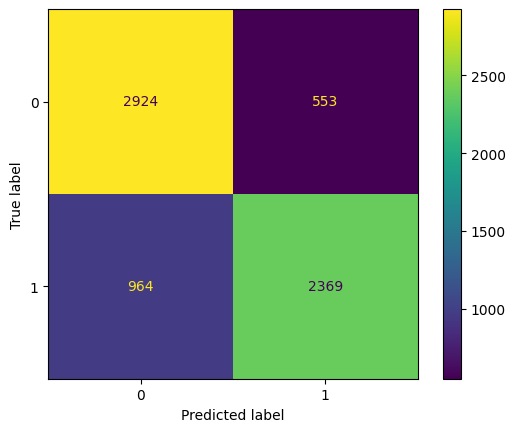

In [70]:
## Making Model
logreg = LogisticRegression(random_state=97)
logreg.fit(x_train_combined_logistic, y_train)

y_pred_proba = logreg.predict_proba(x_test_processed_logistic)
y_pred_logistic = [1 if proba[1] > cutoff else 0 for proba in y_pred_proba]
confusion_matrix = metrics.confusion_matrix(y_test_true, y_pred_logistic)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [71]:
print(classification_report(y_test_true, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      3477
           1       0.81      0.71      0.76      3333

    accuracy                           0.78      6810
   macro avg       0.78      0.78      0.78      6810
weighted avg       0.78      0.78      0.78      6810



### SVM

In [72]:
x_test_processed_svm

,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop,...,20,21,22,23,24,25,26,27,28,29
17038,125,0.071,0.871,0.057,-0.4348,0.000,1.000,0.000,0.0000,0.000000,...,0.030835,-0.035248,0.032542,0.029264,-0.007650,0.001372,-0.048125,0.035086,-0.020518,0.004277
7623,529,0.047,0.781,0.172,0.9965,0.000,0.777,0.223,0.3182,0.015123,...,0.023354,0.030838,-0.058514,-0.016016,-0.046442,0.013484,0.118385,0.006500,-0.025981,-0.017103
1647,742,0.196,0.707,0.097,-0.9981,0.000,1.000,0.000,0.0000,0.000000,...,0.001275,0.005148,-0.023335,0.001451,-0.071579,0.045886,-0.110592,0.032865,0.011443,0.183286
4727,675,0.136,0.742,0.122,-0.9631,0.248,0.537,0.215,-0.1280,0.002963,...,0.004367,-0.039155,0.028342,0.034701,0.001633,-0.010230,-0.024561,0.029941,0.002166,-0.018580
13379,392,0.036,0.773,0.191,0.9958,0.000,1.000,0.000,0.0000,0.005102,...,0.069556,0.045211,0.054820,-0.013221,-0.032012,-0.033817,-0.021252,0.021226,0.087576,0.033062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,362,0.041,0.719,0.240,0.9979,0.000,0.795,0.205,0.2023,0.005525,...,-0.027556,-0.023877,0.014637,0.032275,0.002712,0.025432,-0.026589,0.013795,-0.001681,0.022990
8973,460,0.200,0.701,0.099,-0.9968,0.301,0.699,0.000,-0.6486,0.000000,...,0.015082,-0.003617,0.028843,0.012257,-0.009914,0.000361,-0.016556,0.022991,-0.012349,-0.012676
6242,126,0.109,0.709,0.182,0.8470,0.000,1.000,0.000,0.0000,0.007937,...,-0.030000,0.012923,-0.001232,-0.003500,0.007088,-0.020003,0.010257,0.024363,0.032329,-0.005185
9319,161,0.212,0.737,0.051,-0.9806,0.273,0.727,0.000,-0.6705,0.000000,...,-0.071220,-0.004366,-0.031718,-0.015787,-0.022002,-0.038197,0.005204,0.019201,0.021844,-0.005555


In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_combined_svm)
x_test_scaled = scaler.transform(x_test_processed_svm)
svm = SVC(kernel="linear", C=1.0, gamma="scale", probability=True, random_state=100)
svm.fit(x_train_scaled, y_train)

# y_pred = svm.predict(x_test_scaled)
y_probs = svm.predict_proba(x_test_scaled)[:,1]

In [92]:
y_pred_svm = (y_probs >= cutoff).astype(int)

accuracy = accuracy_score(y_test_true, y_pred_svm)

print(f"Evaluation at Threshold: {cutoff}")
print(f" Accuracy: {accuracy:.3f}")
print(classification_report(y_test_true, y_pred_svm))
print("y_test distribution:", np.bincount(y_test_true))
print("y_pred distribution:", np.bincount(y_pred_svm))

Evaluation at Threshold: 0.8
 Accuracy: 0.813
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3477
           1       0.81      0.81      0.81      3333

    accuracy                           0.81      6810
   macro avg       0.81      0.81      0.81      6810
weighted avg       0.81      0.81      0.81      6810

y_test distribution: [3477 3333]
y_pred distribution: [3462 3348]


### Naive Bayes

In [75]:
X_test['tokens'] = X_test['cleaned_text'].apply(lambda x: x.split())
x_test_combined = sentiment_maker(X_test, "cleaned_text")
x_test_combined = sentiment_maker(x_test_combined, "clean_title")
x_test_combined['percent_stop'] = x_test_combined['tokens'].apply(count_stop_words)
x_test_combined

,id,title,author,text,cleaned_text,clean_title,tokens,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop
17038,17038,McCain: ‘I Don't Know' If Trump-Russia Dossier...,Pam Key,Wednesday on CNN addressing media reports that...,wednesday cnn addressing medium report turned ...,mccain dont know trumprussia dossier credible ...,"[wednesday, cnn, addressing, medium, report, t...",0.071,0.871,0.057,-0.4348,0.000,1.000,0.000,0.0000,0.000000
7623,7623,Netflix Casts a Wider Net for Original Documen...,Glenn Kenny,"It was early in March 2015, the filmmaker Ava ...",early march filmmaker ava duvernay recalled re...,netflix cast wider net original documentary ne...,"[early, march, filmmaker, ava, duvernay, recal...",0.047,0.781,0.172,0.9965,0.000,0.777,0.223,0.3182,0.015123
1647,1647,"Aleppo Evacuation Effort Restarts, and Assad C...",Ben Hubbard and Hwaida Saad,"BEIRUT, Lebanon — After months of fierce bo...",beirut lebanon month fierce bombardment failed...,aleppo evacuation effort restarts assad call h...,"[beirut, lebanon, month, fierce, bombardment, ...",0.196,0.707,0.097,-0.9981,0.000,1.000,0.000,0.0000,0.000000
4727,4727,Friends Say Minnesota Attacker Was ‘Normal Ame...,Mitch Smith and Richard Pérez-Peña,"ST. CLOUD, Minn. — The man who the police s...",st cloud minn man police say stabbed people ma...,friend say minnesota attacker normal american ...,"[st, cloud, minn, man, police, say, stabbed, p...",0.136,0.742,0.122,-0.9631,0.248,0.537,0.215,-0.1280,0.002963
13379,13379,Nearly Four-Fifths of White Evangelicals Say T...,Laurie Goodstein,Nearly of white evangelical voters plan to c...,nearly white evangelical voter plan cast ballo...,nearly fourfifths white evangelicals say theyl...,"[nearly, white, evangelical, voter, plan, cast...",0.036,0.773,0.191,0.9958,0.000,1.000,0.000,0.0000,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,8325,When a Basic Laptop Will Do: Our Top Budget Pi...,Damon Darlin,"Ever since the advent of the iPhone and iPad, ...",ever since advent iphone ipad people using lap...,basic laptop top budget pick new york time,"[ever, since, advent, iphone, ipad, people, us...",0.041,0.719,0.240,0.9979,0.000,0.795,0.205,0.2023,0.005525
8973,8973,Leader of a Ku Klux Klan Group Is Found Dead i...,Liam Stack,"Frank Ancona, the professed leader of the Trad...",frank ancona professed leader traditionalist a...,leader ku klux klan group found dead missouri ...,"[frank, ancona, professed, leader, traditional...",0.200,0.701,0.099,-0.9968,0.301,0.699,0.000,-0.6486,0.000000
6242,6242,Economic Breadth Is Significantly Deterioratin...,IWB,Economic Breadth Is Significantly Deterioratin...,economic breadth significantly deteriorating u...,economic breadth significantly deteriorating u,"[economic, breadth, significantly, deteriorati...",0.109,0.709,0.182,0.8470,0.000,1.000,0.000,0.0000,0.007937
9319,9319,Keith Lamont Scott Was Killed by Two Gunshot W...,Niraj Chokshi,A black man whose fatal shooting by the pol...,black man whose fatal shooting police septembe...,keith lamont scott killed two gunshot wound fa...,"[black, man, whose, fatal, shooting, police, s...",0.212,0.737,0.051,-0.9806,0.273,0.727,0.000,-0.6705,0.000000


In [76]:
from scipy.sparse import hstack

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

# Extract numerical sentiment & stop-word features
X_train_extra = np.array(X_vec[["pos_cleaned_text", "neu_cleaned_text", "neg_cleaned_text", "percent_stop"]])
X_test_extra = np.array(x_test_combined[["pos_cleaned_text", "neu_cleaned_text", "neg_cleaned_text", "percent_stop"]])

# Stack TF-IDF matrix with additional features
X_train_final = hstack([tfidf_matrix, X_train_extra])
X_test_final = hstack([X_test_tfidf, X_test_extra])
X_train_final

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<COOrdinate sparse matrix of dtype 'float64'
	with 3673604 stored elements and shape (13826, 104221)>

In [115]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


from sklearn.metrics import classification_report, accuracy_score
# Predict on test set
model = BernoulliNB()
model.fit(X_train_final, y_train)
y_pred_nb = model.predict(X_test_final)

pred_prob = model.predict_proba(X_test_final)
y_pred_nb = [1 if proba[1] > cutoff else 0 for proba in pred_prob]

# Print evaluation results
print("Accuracy:", accuracy_score(y_test_true, y_pred_nb))
print(classification_report(y_test_true, y_pred_nb))
print("y_test distribution:", np.bincount(y_test_true))
print("y_pred distribution:", np.bincount(y_pred_nb))

Accuracy: 0.7110132158590309
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      3477
           1       0.64      0.93      0.76      3333

    accuracy                           0.71      6810
   macro avg       0.76      0.72      0.70      6810
weighted avg       0.77      0.71      0.70      6810

y_test distribution: [3477 3333]
y_pred distribution: [1955 4855]


### Ensemble Learning(Bagging)

In [82]:
import numpy as np
from scipy.stats import mode

predictions = np.vstack((y_pred_logistic, y_pred_svm, y_pred_nb))

majority_vote = pd.DataFrame(predictions.transpose()).mode(axis=1)

print("Accuracy:", accuracy_score(y_test_true, majority_vote))
print(classification_report(y_test_true, majority_vote))
print("y_test distribution:", np.bincount(y_test_true))
print("y_pred distribution:", majority_vote.value_counts())

Accuracy: 0.8240822320117475
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3477
           1       0.79      0.88      0.83      3333

    accuracy                           0.82      6810
   macro avg       0.83      0.83      0.82      6810
weighted avg       0.83      0.82      0.82      6810

y_test distribution: [3477 3333]
y_pred distribution: 0
1    3723
0    3087
Name: count, dtype: int64


In [83]:
metrics.confusion_matrix(y_test_true, majority_vote)

array([[2683,  794],
       [ 404, 2929]])

### Modified Ensemble Learning
Trying to take the mean proability of each model then applying cutoff

In [117]:
probs_df = pd.DataFrame({
    'SVM_Proba': svm.predict_proba(x_test_scaled)[:,1],
    'Bayes_Proba': model.predict_proba(X_test_final)[:,1],
    'LogReg_Proba': logreg.predict_proba(x_test_processed_logistic)[:,1]
})

probs_df['Mean_Proba'] = probs_df.mean(axis=1)
predict_y = [1 if proba > cutoff else 0 for proba in probs_df['Mean_Proba']]

print("Accuracy:", accuracy_score(y_test_true, predict_y))
print(classification_report(y_test_true, predict_y))

Accuracy: 0.7649045521292217
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      3477
           1       0.69      0.93      0.79      3333

    accuracy                           0.76      6810
   macro avg       0.80      0.77      0.76      6810
weighted avg       0.80      0.76      0.76      6810



/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
